### Population Segmentation on Social determinants of health and chronic diseases

<span style="font-size:14px">
Analysis of the 2022 PLACES (Population Level Analysis and Community Estimates) data from the CDC and the 2020 American Community Survey
</span>

***Andre Nana***

#### 1. Purpose

<span style="font-size:12px">

We have already collected and performed exploratory data analysis on community-level social determinants of health (SDOH) and chronic disease indicators. These data were derived from two complementary sources: the 2022 CDC PLACES dataset (Population Level Analysis and Community Estimates), which provides model-based estimates of health behaviors, risk factors, and preventive service use at the census tract and ZCTA levels, and the 2020 American Community Survey (ACS) 5-year estimates, which offer socio-demographic measures such as income, education, housing, and transportation access. All data cleaning, merging, and visualization steps are documented in the GitHub repository “Python-data-cleaning-merging-visualization-and-modeling.”

Building on this foundation, we apply unsupervised machine learning methods to identify clusters of ZIP Code Tabulation Areas (ZCTAs) that share similar social and health profiles. By using approaches such as k-means, hierarchical clustering, and density-based clustering (DBSCAN), we aim to uncover latent community typologies that may not be apparent from descriptive analysis alone. These clusters can highlight geographic patterns of vulnerability, reveal co-occurring risk factors, and support the design of targeted public health interventions tailored to specific community contexts.

The data was analyzed using Python 313 on VS code.
</span>

<span style="font-size:12px">
Disclaimer:
This analysis is intended for educational and research purposes only and has not been peer-reviewed. While efforts have been made to ensure the accuracy of the methods and results, the author does not guarantee the correctness or completeness of the analysis. The author bears no responsibility or liability for any errors, omissions, or outcomes resulting from the use of this material. Use at your own discretion.


#### 2. Importing required libraries and data

In [1]:
# ==========================
# Standard Libraries
# ==========================
import math
import warnings
from collections import OrderedDict

# ==========================
# Data Handling
# ==========================
import numpy as np
import pandas as pd
import requests

# ==========================
# Visualization
# ==========================
import matplotlib.pyplot as plt
import missingno as msno        # Visualizing missing data
import seaborn as sns

# ==========================
# Statistical Analysis
# ==========================
import statsmodels.api as sm
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
from scipy.stats import chi2_contingency, kruskal
from tableone import TableOne

# ==========================
# Clustering / Machine Learning
# ==========================
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# ==========================
# External Data (Census API)
# ==========================
from census import Census      
from us import states

# ==========================
# Config
# ==========================
warnings.filterwarnings("ignore")  # Suppress warnings

# ==========================
# Data
# ==========================
acsplaces = pd.read_csv("acsplaces.csv")

#### 2. Data manipulation

<span style="font-size:12px">

Although machine learning — particularly unsupervised methods — is generally robust to violations of traditional statistical assumptions, it is still essential to examine the underlying data before applying these techniques. Exploring the distributions, identifying skewness, and detecting outliers not only helps guide preprocessing decisions such as scaling or transformation but also improves the interpretability of the resulting clusters or components. This practice ensures that the analysis reflects meaningful patterns in the data rather than artifacts of measurement, coding, or extreme values, ultimately strengthening the validity of insights drawn from unsupervised models.

##### 2.1 List of variables and overview of data

<span style="font-size:12px">


- **edentulism_65plus** : All teeth lost among adults aged ≥65 years
- **arthritis** : Arthritis among adults aged ≥18 years
- **binge_drinking** : Binge drinking among adults aged ≥18 years
- **cancer** : Cancer (excluding skin cancer) among adults aged ≥18 years
- **cervical_screening** : Cervical cancer screening among adult women aged 21–65 years
- **cholesterol_screening** : Cholesterol screening among adults aged ≥18 years
- **ckd** : Chronic kidney disease among adults aged ≥18 years
- **copd** : Chronic obstructive pulmonary disease among adults aged ≥18 years
- **chd** : Coronary heart disease among adults aged ≥18 years
- **asthma** : Current asthma among adults aged ≥18 years
- **no_insurance_18_64** : Current lack of health insurance among adults aged 18–64 years
- **smoking** : Current smoking among adults aged ≥18 years
- **depression** : Depression among adults aged ≥18 years
- **diabetes** : Diagnosed diabetes among adults aged ≥18 years
- **poor_health** : Fair or poor self-rated health status among adults aged ≥18 years
- **colorectal_screening** : Fecal occult blood test, sigmoidoscopy, or colonoscopy among adults aged 50–75 years
- **hypertension** : High blood pressure among adults aged ≥18 years
- **high_cholesterol** : High cholesterol among adults aged ≥18 years who have been screened in the past 5 years
- **mammography** : Mammography use among women aged 50–74 years
- **mental_distress** : Mental health not good for ≥14 days among adults aged ≥18 years
- **physical_inactivity** : No leisure-time physical activity among adults aged ≥18 years
- **obesity** : Obesity among adults aged ≥18 years
- **preventive_men_65plus** : Older adult men aged ≥65 years who are up to date on a core set of clinical preventive services (flu shot past year, PPV shot ever, colorectal cancer screening)
- **preventive_women_65plus** : Older adult women aged ≥65 years who are up to date on a core set of clinical preventive services (flu shot past year, PPV shot ever, colorectal cancer screening, mammogram past 2 years)
- **physical_distress** : Physical health not good for ≥14 days among adults aged ≥18 years
- **short_sleep** : Sleeping less than 7 hours among adults aged ≥18 years
- **stroke** : Stroke among adults aged ≥18 years
- **bp_meds** : Taking medicine for high blood pressure control among adults aged ≥18 years with high blood pressure
- **dental_visit** : Visits to dentist or dental clinic among adults aged ≥18 years
- **routine_checkup** : Visits to doctor for routine checkup within the past year among adults aged ≥18 years

In [2]:
rows, column = acsplaces.shape
print('The dataset contains', rows, 'rows and', column, 'columns.')

The dataset contains 32409 rows and 38 columns.


In [3]:
#checking for the data type
print('The data type of each attribute: \n')
acsplaces.info()

The data type of each attribute: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32409 entries, 0 to 32408
Data columns (total 38 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ZCTA                        32409 non-null  int64  
 1   Median_Household_Income     30358 non-null  float64
 2   Pct_Below_Poverty           32310 non-null  float64
 3   Pct_Unemployed              32133 non-null  float64
 4   Pct_No_High_School_Diploma  32310 non-null  float64
 5   Pct_Renter_Occupied         32072 non-null  float64
 6   Pct_No_Vehicle              32072 non-null  float64
 7   Pct_Uninsured_18_24         32310 non-null  float64
 8   edentulism_65plus           32230 non-null  float64
 9   arthritis                   32409 non-null  float64
 10  binge_drinking              32409 non-null  float64
 11  cancer                      32409 non-null  float64
 12  cervical_screening          32400 non-null  float64
 

In [4]:
#5-point summary
acsplaces.drop(columns=['ZCTA']).describe().T.round(3)

,count,mean,std,min,25%,50%,75%,max
Median_Household_Income,30358.0,63634.036,27222.683,2499.0,46458.000,57985.000,74144.750,250001.000
Pct_Below_Poverty,32310.0,12.822,10.630,0.0,5.884,10.490,16.951,100.000
Pct_Unemployed,32133.0,5.387,6.217,0.0,2.219,4.247,6.701,100.000
Pct_No_High_School_Diploma,32310.0,8.061,7.184,0.0,3.593,6.481,10.599,100.000
Pct_Renter_Occupied,32072.0,26.199,17.795,0.0,14.368,22.840,33.766,100.000
Pct_No_Vehicle,32072.0,6.151,9.256,0.0,1.504,3.888,7.322,100.000
Pct_Uninsured_18_24,32310.0,1.278,2.537,0.0,0.000,0.531,1.473,74.138
edentulism_65plus,32230.0,15.395,5.730,3.3,11.500,14.600,18.600,53.900
arthritis,32409.0,26.700,5.968,1.7,23.200,27.000,30.400,66.000
binge_drinking,32409.0,16.849,3.178,2.1,14.800,16.700,18.700,40.400


<span style="font-size:12px">

##### 2.2 Distribution of variables

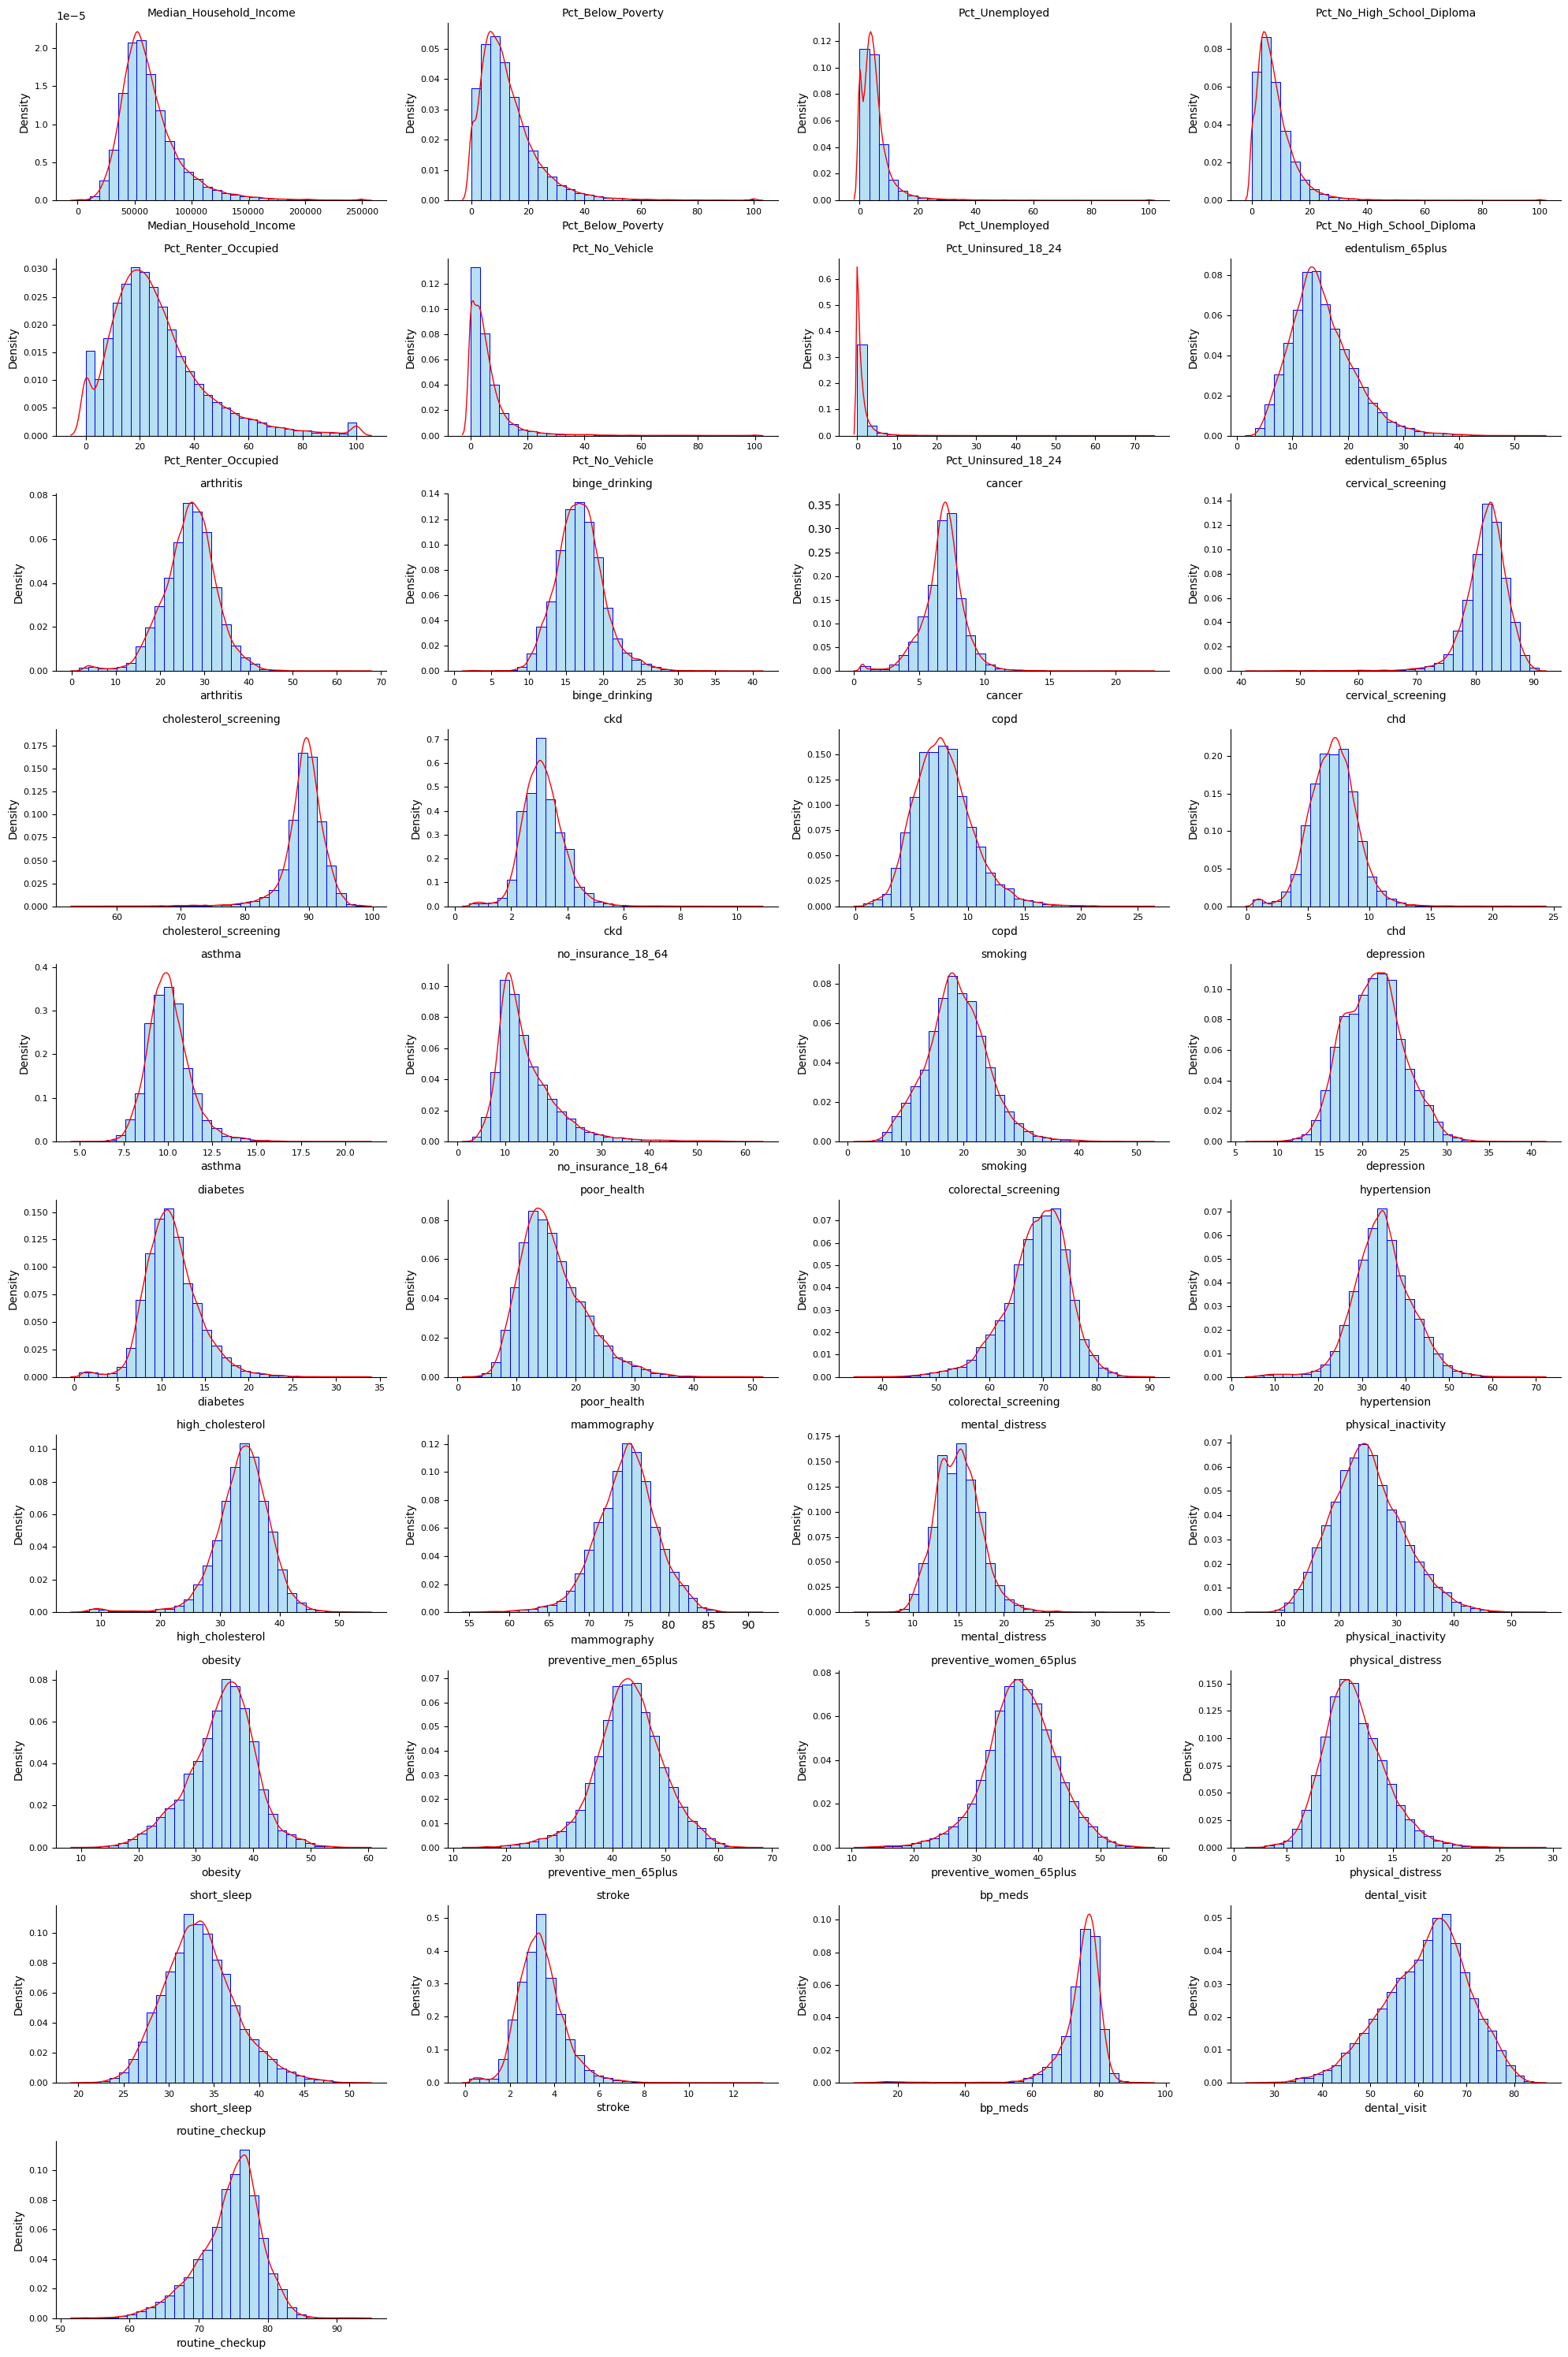

In [5]:
# List of variables (remove ZCTA)
vars_to_plot = acsplaces.drop(columns=['ZCTA']).columns.tolist()

# Grid size
ncols = 4
nrows = -(-len(vars_to_plot) // ncols)  # ceiling division

plt.figure(figsize=(20, nrows*3))

for i, var in enumerate(vars_to_plot):
    plt.subplot(nrows, ncols, i+1)
    
    # Histogram normalized to density scale
    sns.histplot(
        acsplaces[var].dropna(),
        bins=30,
        stat="density",   # ensures histogram is on same scale as KDE
        color="skyblue",
        alpha=0.6,
        edgecolor="blue"   # removes black borders          
    )
    
    # Density plot (explicit, with custom color)
    sns.kdeplot(
        acsplaces[var].dropna(),
        color="red",
        lw=1,
        bw_adjust=0.8    # tweak smoothness if needed
    )
    
    plt.title(var, fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    sns.despine()

plt.tight_layout()
plt.show()

<span style="font-size:12px">
A quick visualization reassures us that there are no aberations such as percentages above 100.
There is no unique pattern. Some variables such as physical activity and copd look normally distributed. However, most variables are skewed to the right (median household income, percentage of renter occupied etc).

##### 2.3 Missing values

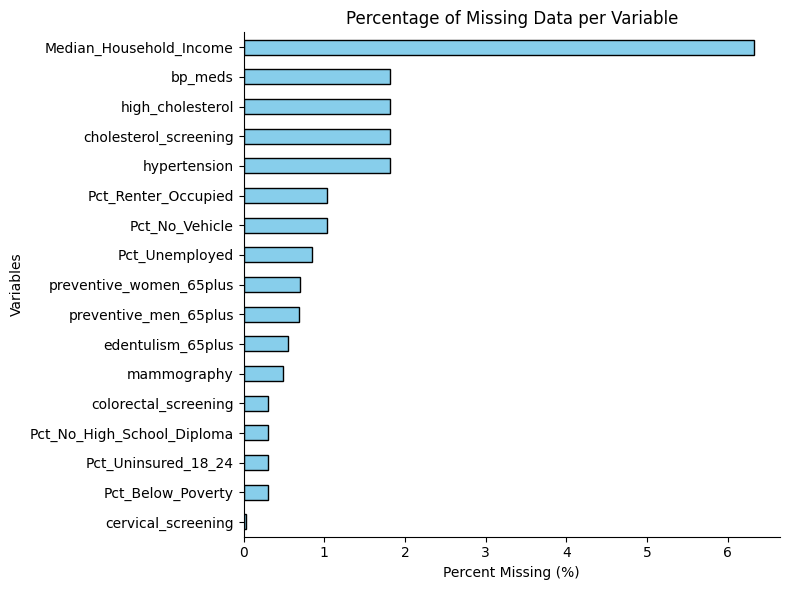

In [6]:

# Calculate % missing
missing_percent = acsplaces.isnull().mean() * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=True)

# Plot
plt.figure(figsize=(8,6))
ax = missing_percent.plot(kind="barh", color="skyblue", edgecolor="black")

# Titles and labels
plt.title("Percentage of Missing Data per Variable", fontsize=12)
plt.xlabel("Percent Missing (%)")
plt.ylabel("Variables")

# Clean up borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


<span style="font-size:12px">
Median household income appears to have the highest percentage of missing values

Axes(0.125,0.11;0.775x0.77)


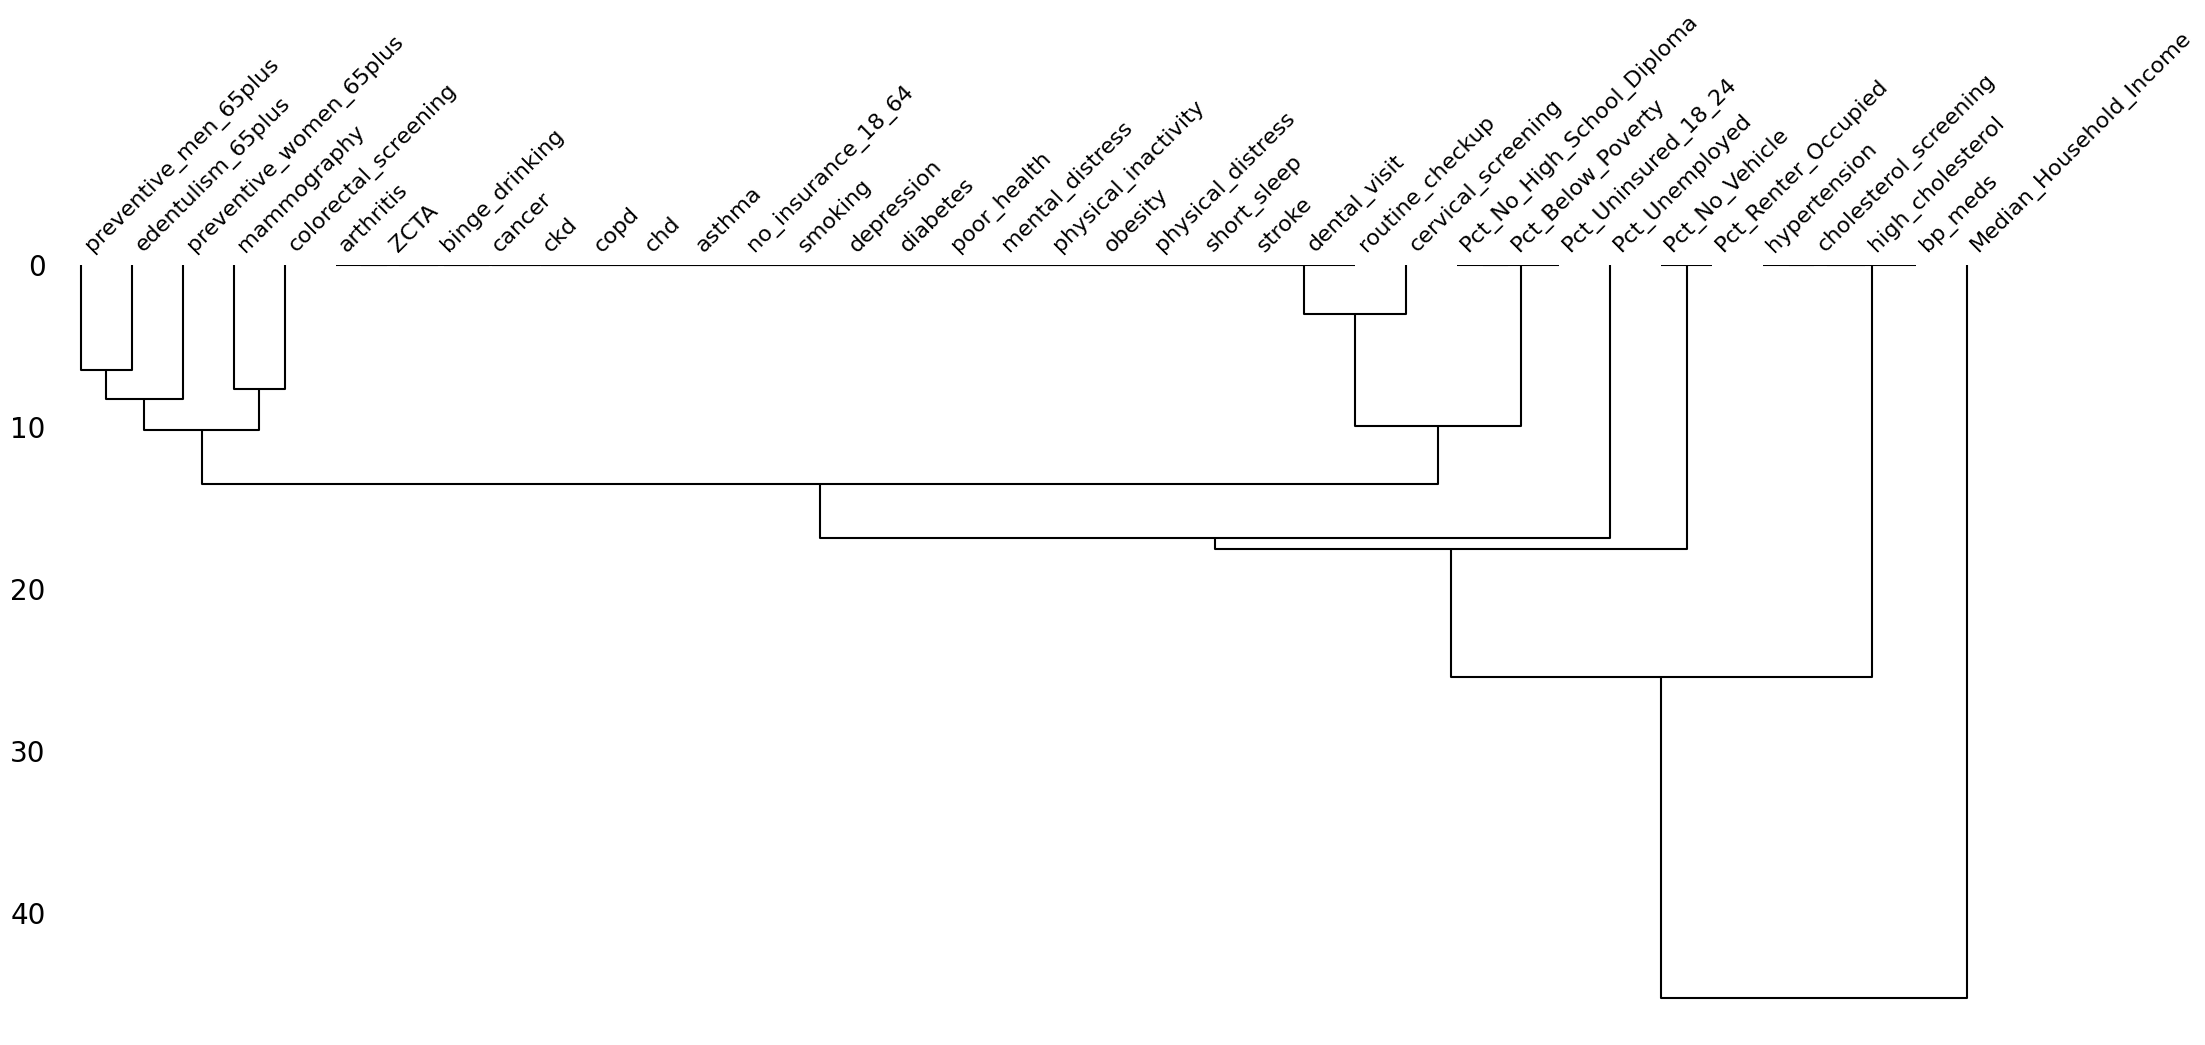

In [7]:
print(msno.dendrogram(acsplaces))

<span style="font-size:12px">
This dendrogram provides a hierarchical clustering of the variables. We have on the left, a cluster of variables missing values at the same time such as edulism, percentage of men or women up-to-date on their preventative care, mammography and colorectal screnning

#### 3. Machine learning models

In [8]:
# We wil retain all features, except for ZCTA which is the geographic indicator
features = acsplaces.drop(columns=['ZCTA']).columns.tolist()

# Subset and scale
X = acsplaces[features].dropna() # We will drop all missing values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

##### 3.1 K-means clustering

<span style="font-size:12px">
K-means clustering is one of the most widely used unsupervised machine learning methods for identifying hidden structures in complex datasets. The algorithm partitions observations into k distinct groups, or clusters, such that each observation belongs to the cluster with the nearest centroid (mean value). This approach minimizes within-cluster variance while maximizing between-cluster separation, producing groups of observations that are internally similar yet distinct from other groups.
In this analysis, we aim to identify clusters of ZIP Code Tabulation Areas (ZCTAs) that exhibit similar patterns across both social determinants of health (such as poverty, unemployment, lack of insurance, education, and housing characteristics) and chronic disease indicators, including obesity, diabetes, hypertension, smoking, and preventive service use.


- Building the model and plotting elbow plot and silhouette plot

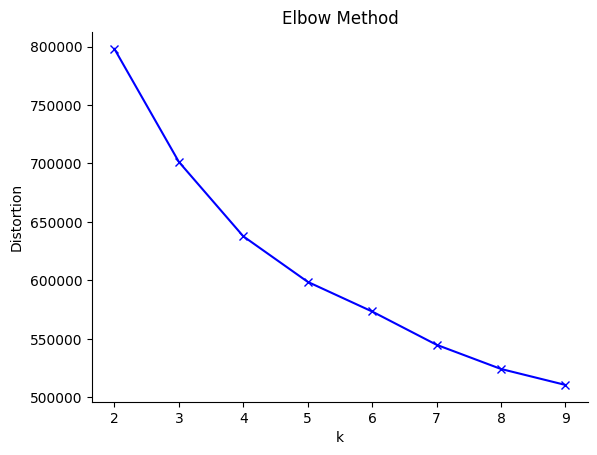

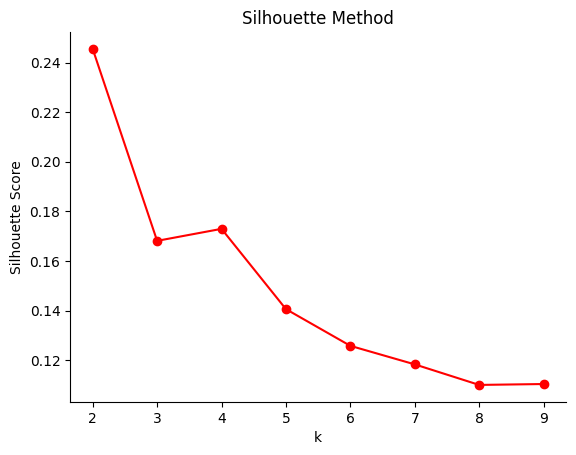

In [9]:
# Initialize empty lists to store evaluation metrics for each k
distortions = []   # will store inertia values (within-cluster sum of squares)
silhouettes = []   # will store silhouette scores

# Define the range of cluster numbers to test
K = range(2, 10)   # test k from 2 to 9 clusters

# Loop through each candidate number of clusters
for k in K:
    # Initialize KMeans with current k
    kmeans = KMeans(n_clusters=k, random_state=42)

    # Fit KMeans to the scaled data and get cluster labels for each observation
    labels = kmeans.fit_predict(X_scaled)

    # Save the "distortion" (inertia = sum of squared distances to closest cluster center)
    distortions.append(kmeans.inertia_)

    # Save the silhouette score (measures cluster separation and cohesion)
    silhouettes.append(silhouette_score(X_scaled, labels))


# Elbow plot
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

# Silhouette scores
plt.plot(K, silhouettes, 'ro-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

<span style="font-size:12px">

- Elbow Method (top plot): The distortion (within-cluster variance) decreases rapidly up to around 𝑘=3 or 𝑘=4, after which the curve flattens a little bit, suggesting a diminishing returns from adding more clusters beyond this point.

- Silhouette Method (bottom plot): The silhouette score is highest at 𝑘=2, indicating the strongest separation at two clusters. Scores drop notably after 𝑘=3, and remain relatively low for higher values, suggesting weaker cohesion/separation.

The optimal clustering solution likely lies between 2 and 4 clusters. While the silhouette favors 2 clusters for clearer separation, the elbow method suggests that 3–4 clusters may balance compactness and interpretability.

We will keep a final cluster number of 𝑘=4.

- Building the model with k=4, visualizing data per cluster

In [10]:
# Fit KMeans with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# Save labels to dataframe
acsplaces.loc[X.index, "Cluster_Km"] = labels

# Compute cluster-level summary
cluster_km_summary = acsplaces.groupby("Cluster_Km")[features].mean().round(2)

# Get evaluation metrics
distortion = kmeans.inertia_  # within-cluster sum of squares
silhouette = silhouette_score(X_scaled, labels)  # silhouette score

# Print results
print(f"Distortion = {distortion:.2f}")
print(f"Silhouette = {silhouette:.3f}")
cluster_km_summary


Distortion = 637721.51
Silhouette = 0.173


,Median_Household_Income,Pct_Below_Poverty,Pct_Unemployed,Pct_No_High_School_Diploma,Pct_Renter_Occupied,Pct_No_Vehicle,Pct_Uninsured_18_24,edentulism_65plus,arthritis,binge_drinking,...,physical_inactivity,obesity,preventive_men_65plus,preventive_women_65plus,physical_distress,short_sleep,stroke,bp_meds,dental_visit,routine_checkup
Cluster_Km,,,,,,,,,,,,,,,,,,,,,
0.0,55594.81,16.95,6.86,11.85,45.52,10.52,2.23,16.50,20.19,17.92,...,26.30,34.11,37.59,32.14,11.24,34.75,2.91,67.25,55.71,69.22
1.0,41323.64,21.76,7.85,13.00,28.41,9.28,1.70,23.15,31.99,14.17,...,33.27,40.66,38.61,33.06,15.27,37.78,4.69,77.99,50.92,77.02
2.0,90674.83,6.55,3.79,3.98,24.21,4.49,0.71,9.60,22.44,18.52,...,18.50,29.36,48.45,42.04,8.41,30.54,2.44,72.64,70.93,73.52
3.0,58093.97,11.11,4.53,6.90,21.20,4.37,1.24,14.94,28.79,16.81,...,24.98,35.20,43.72,37.79,11.41,32.92,3.51,77.11,62.85,75.41


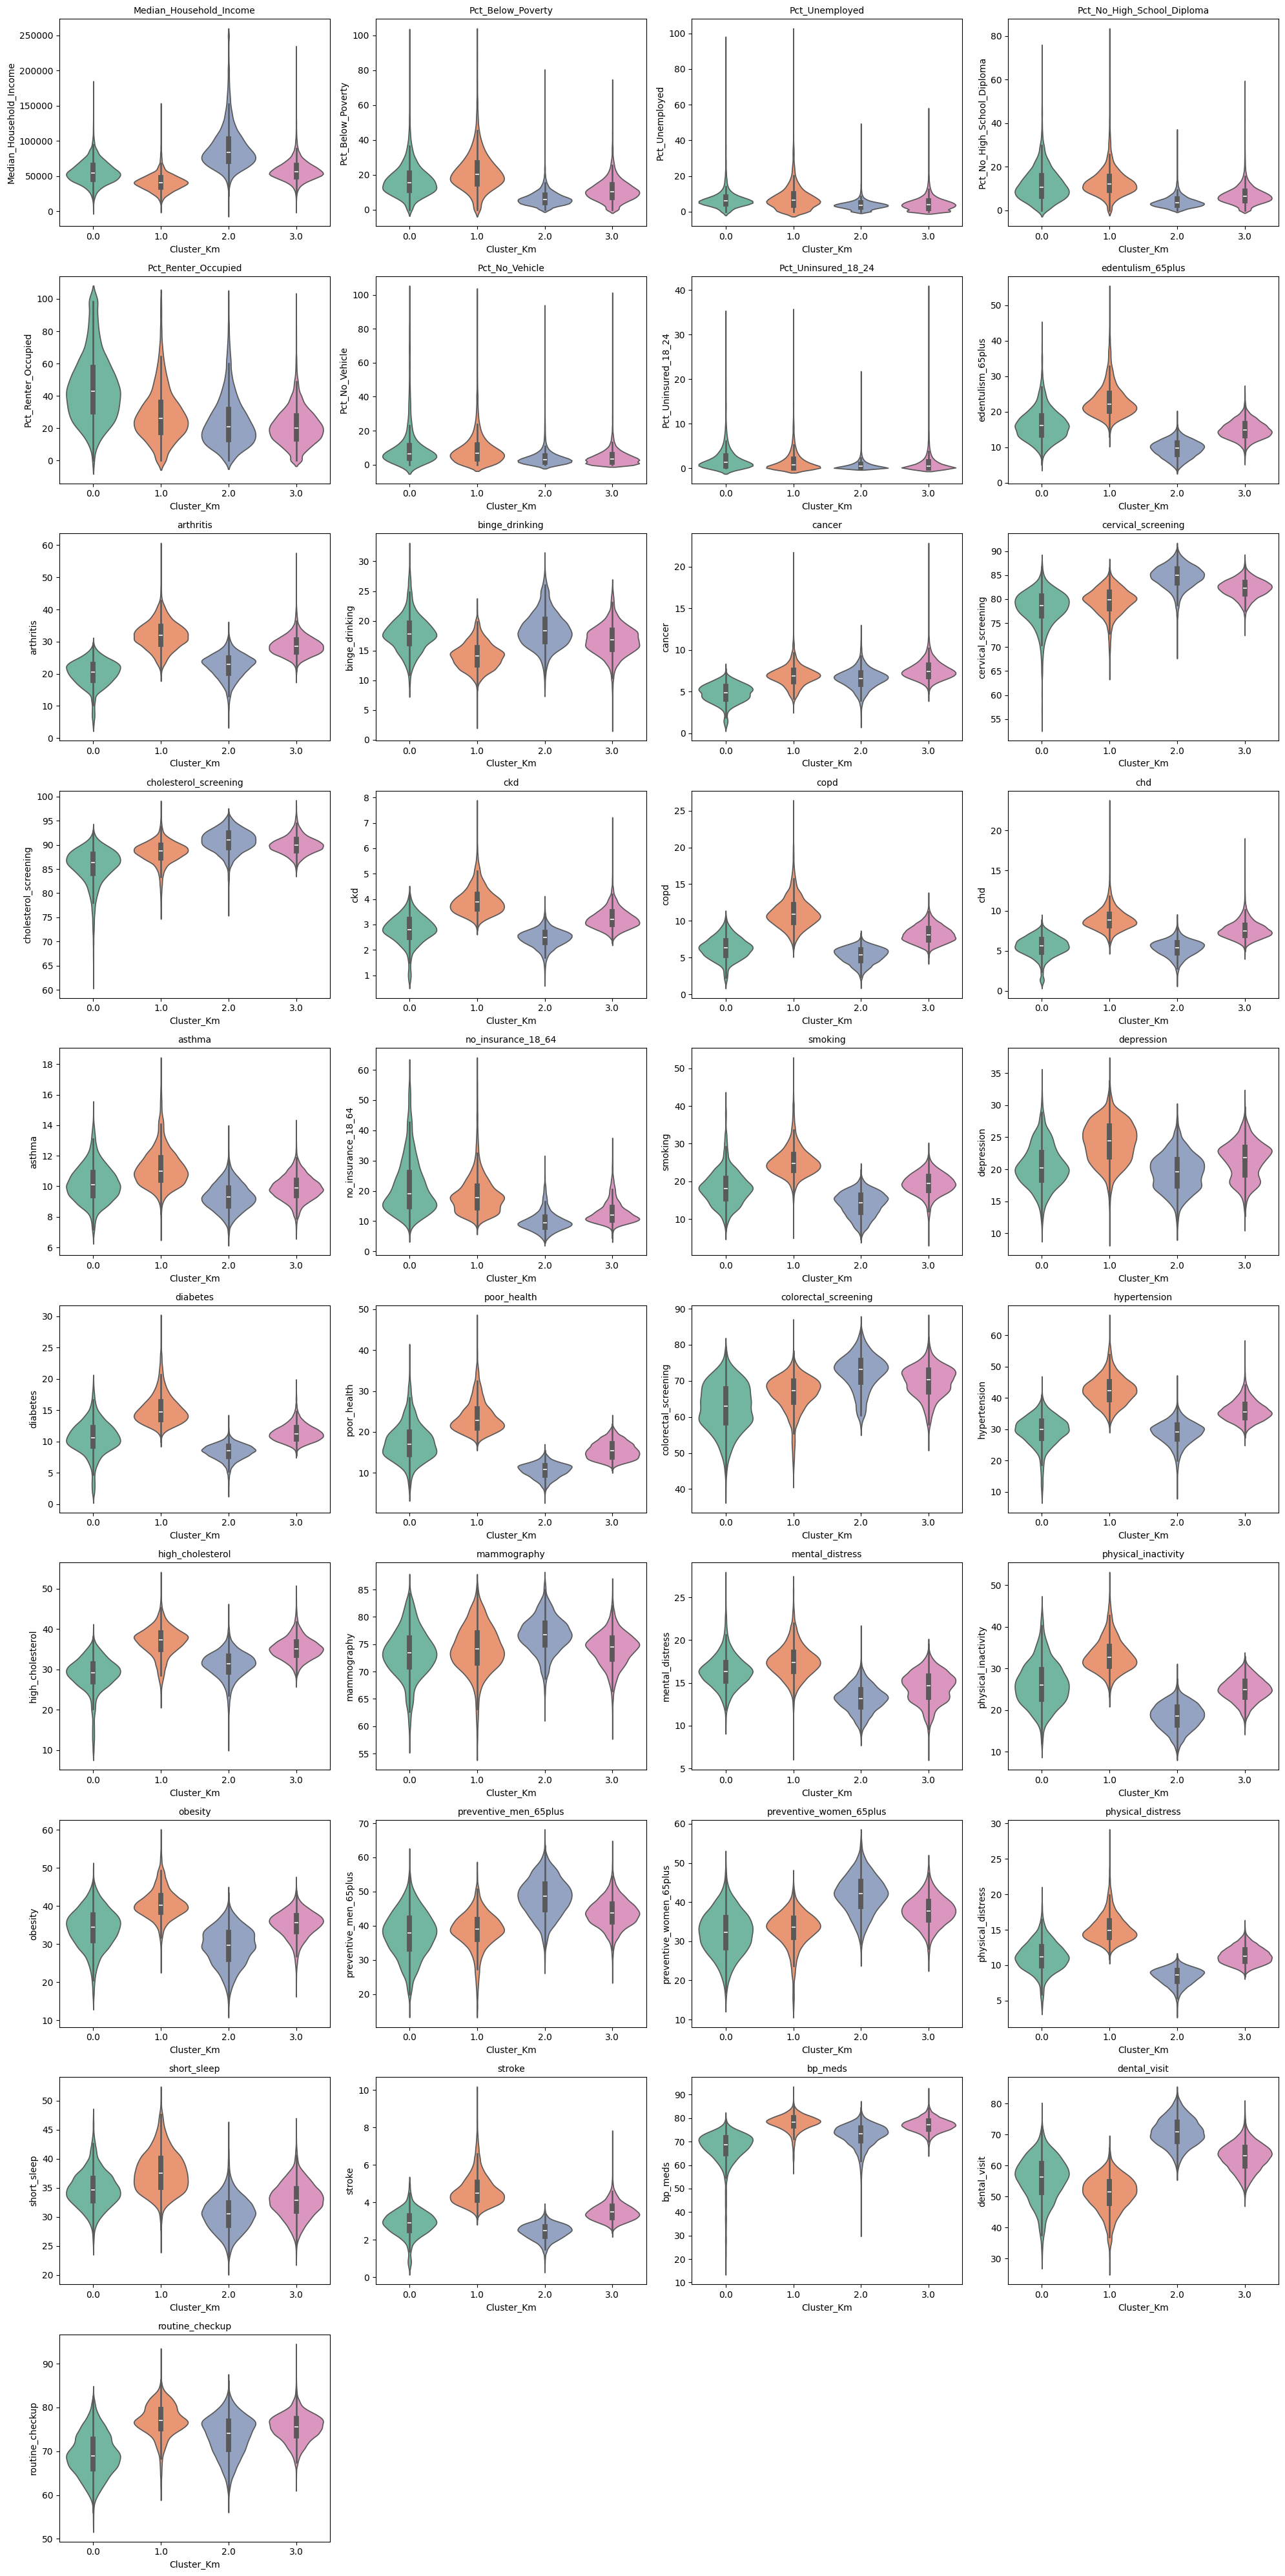

In [11]:
# violin plot
# Number of columns in the grid
ncols = 4
nrows = -(-len(features) // ncols)  # ceiling division

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows*4))
axes = axes.flatten()

# Loop through each feature and create a violin plot
for i, col in enumerate(features):
    sns.violinplot(
        data=acsplaces, 
        x="Cluster_Km", 
        y=col, 
        palette="Set2", 
        inner="box", 
        ax=axes[i]
    )
    axes[i].set_title(col, fontsize=10)

# Hide unused subplots if any
for j in range(len(features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


<span style="font-size:12px">
Conclusion

The K-means clustering analysis revealed four distinct community profiles, largely differentiated by socioeconomic status and corresponding health burdens:

- Cluster 1 - orange (Lowest SES, poorest health outcomes) represents communities with the highest poverty, unemployment, and chronic disease prevalence. 
- Cluster 2 - pink (Highest SES, healthiest outcomes) demonstrates the positive health gradient associated with economic security. 
- Clusters 0 - green, and 3 - pink (Moderate SES, intermediate health risks) 

K-means clustering appears to successfully group ZCTAs in a way that reflects an inverse relationship between median household income and adverse health outcomes. At the same time, higher income levels show a positive correlation with health-seeking behaviors, such as preventive service use, which aligns with expectations. Nonetheless, these findings should be interpreted cautiously. The patterns observed may reflect underlying data structure rather than causal relationships, and therefore no direct policy conclusions should be drawn without further validation and contextual analysis.

<span style="font-size:12px; font-style:italic;">
I would be very happy to discuss any findings and would be grateful to have any mistakes — should any have escaped my attention — pointed out.
Thank you for reading!
</span>